# Water Budget Validation

This framework provides an automated testing infrastructure for new vadose zone and groundwater zone models. You can specify custom classes representing either/both of these models and ensure that total water having entered the system is equal to the total change in zone stocks plus total cumulative output fluxes.

This testing framework only requires that: 

 * Both the vadose zone and groundwater zone models have `update` methods which return a dictionary of fluxes. 
 * The vadoze zone flux dictionary contains the key `leakage` -- this leakage will be routed to the groundwater zone. 

Because leakage is routed internally in the vadose-groundwater system, it will not be charted as one of the incoming or outgoing fluxes on the figure produced below. In all other cases, dummy flux dictionaries are first traversed to obtained a list of all fluxes to be tracked for each zone. These are then updated at each step along the synthetic rainfall time series. The combined vadose-groundwater model is conserving mass if the total volume trace does not deviate from 1. 

In [1]:
%matplotlib inline
from vadoseZone import LaioVadoseZone, PorporatoVadoseZone
from groundwaterZone import GroundwaterZone, LinearReservoir
from REW import REW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

/Users/nathankarst/anaconda/envs/py2k_gis/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def generateSyntheticRainfall(numIntervals=365*24,L=10/30/24,alpha=20):
    ''' Generate synthetic rainfall time series modeled by a marked Poisson process with interarrival time 1/L and average depth per event alpha
    '''
    return np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-L) else 0.0 for i in range(numIntervals)])

In [3]:
def waterBudget(vz=LaioVadoseZone,gz=LinearReservoir): 
    ## time domain
    Tmax    = 365*5.               # days (or whatever)
    dt      = 1/24.               
    t       = np.linspace(0,Tmax,np.ceil(Tmax/dt))

    ## rainfall statistics
    alpha       = 2.5               # [cm / event]
    L           = 10/30.            # [events / day]

    rainfall = generateSyntheticRainfall(len(t),L*dt,alpha)/dt # [cm/d]

    rew = REW(vz,gz,**{'ppt':rainfall})

    ## init. 
    VzFluxHist = {}
    GzFluxHist = {}
    
    vzFluxes = rew.vz.update(dt,**{'ppt':0})
    for key in vzFluxes.keys(): VzFluxHist[key] = np.zeros(np.size(t))

    gzFluxes = rew.gz.update(dt,**{'leakage':0})
    for key in gzFluxes.keys(): GzFluxHist[key] = np.zeros(np.size(t))        
        
    vadozeStorage   = np.zeros(np.size(t))
    groundwater     = np.zeros(np.size(t))

    for i in range(len(rainfall)):
        vzFluxes = rew.vz.update(dt,**{'ppt':rew.ppt[i]})
        for key in vzFluxes.keys(): VzFluxHist[key][i] = vzFluxes.get(key,0) # [cm/d]
        
        vadozeStorage[i]    = rew.vz.storage # [cm]
        
        gzFluxes = rew.gz.update(dt,**{'leakage':rew.vz.leakage}) 
        for key in gzFluxes.keys(): GzFluxHist[key][i] = gzFluxes.get(key,0) # [cm/d]

        groundwater[i]  = rew.gz.groundwater # [cm]


    YtdWater       = np.cumsum(rew.ppt)*dt # [cm]

    totalVolume = np.zeros(np.size(t)) # [cm]
    
    plt.plot(t,vadozeStorage/YtdWater,label='Vadoze Storage')
    plt.plot(t,groundwater/YtdWater,label='Groundwater Storage')  
    
    totalVolume += vadozeStorage + groundwater
    
    for key in VzFluxHist.keys(): 
        if key == 'leakage': continue
        cumulativeFlux = np.cumsum(VzFluxHist[key])*dt # [cm]
        plt.plot(t,cumulativeFlux/YtdWater,label=key)
        totalVolume += cumulativeFlux
    for key in GzFluxHist.keys(): 
        cumulativeFlux = np.cumsum(GzFluxHist[key])*dt # [cm]
        plt.plot(t,cumulativeFlux/YtdWater,label=key)
        totalVolume += cumulativeFlux        
        
    
    plt.plot(t,totalVolume/YtdWater,label='Total Volume')
    plt.ylabel('Portion of Water Balance []')
    plt.xlabel('Time [d]')
    plt.legend()
    plt.ylim(0,1.25)
    plt.show()

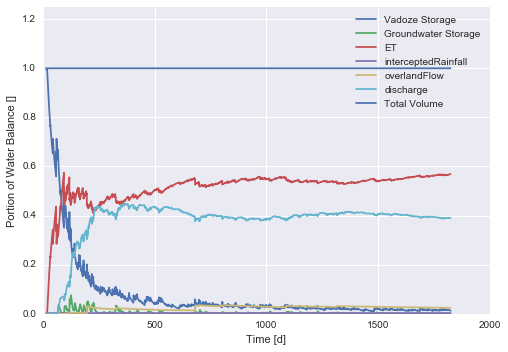

In [4]:
waterBudget()